In [2]:
%matplotlib notebook

import matplotlib.pyplot as plt

import os
import json
import datetime

import numpy as np

In [3]:
paths = [
    os.path.join('..', 'command.out'),
    os.path.join('..', 'command.101932170.out'),
    os.path.join('..', 'command.114164404.out'),
    os.path.join('..', 'command.123858795.out'),
]

In [4]:
class FilterHelper():
    def __init__(self):
        self.cache = dict()
    
    def check(self, key):
        exists = self.cache.get(key, False)
        if not exists:
            self.cache[key] = True
        return exists
    
class AugmentHelper():
    def augment(self, msg):
        msg['date'] = ts2date(msg['timestamp'])
        return msg
    
def ts2date(ts):
    return datetime.datetime.fromtimestamp(int(ts)).strftime('%Y-%m-%d')

def uniqify(messages):
    helper = FilterHelper()
    return [m for m in messages if not helper.check(m['id'])]

def augment(messages):
    helper = AugmentHelper()
    return [helper.augment(m) for m in messages]

def read_messages(paths):
    # Read All
    messages = []
    for path in paths:
        with open(path) as f:
            messages += json.loads(f.read())['messages']
    print("Read {} messages.".format(len(messages)))
    messages = augment(uniqify(messages))
    print("{} unique messages.".format(len(messages)))
    return messages

messages = read_messages(paths)
len(messages)

Read 24652 messages.
24649 unique messages.


24649

In [5]:
messages[0]

{'client': 'website',
 'sender_full_name': "Andrew Drozdov (SP1'15)",
 'subject_links': [],
 'sender_id': 7630,
 'avatar_url': 'https://zulip-avatars.s3.amazonaws.com/13/ea5ab7f7d6e19ffdee32487a6e145475c956689b?x=x&version=1',
 'id': 41022136,
 'recipient_id': 41651,
 'stream_id': 27333,
 'sender_realm_str': 'recurse',
 'sender_email': 'andrew@mrdrozdov.com',
 'sender_short_name': 'andrew',
 'flags': ['read'],
 'content': "Checkins, Monday through Thursday, at 10:30pm EST. One thread per day. Will have to figure out the multi-region issue, but we'll get there.",
 'timestamp': 1434148194,
 'content_type': 'text/x-markdown',
 'reactions': [],
 'type': 'stream',
 'subject': 'Overview',
 'is_me_message': False,
 'display_recipient': 'alumni-checkins',
 'date': '2015-06-12'}

In [6]:
alumni_bot_messages = [m for m in messages if 'alumni-bot' in m['sender_email']]
alumni_bot_ids = [m['id'] for m in alumni_bot_messages]
print(len(alumni_bot_messages))
print(alumni_bot_messages[-1])

1143
{'sender_email': 'alumni-bot@students.hackerschool.com', 'is_me_message': False, 'subject': 'Checkins! Tuesday. April 10, 2018', 'content': 'Welcome to [checkins](https://gist.githubusercontent.com/mrdrozdov/bfd8d218a9414ce11b4d/raw/a23ff8cf560ef6fa60893bade9d05c5fc7f12313/alumin-checkins.txt)!', 'sender_id': 8152, 'flags': ['read'], 'subject_links': [], 'content_type': 'text/x-markdown', 'submessages': [], 'client': 'curl', 'reactions': [], 'display_recipient': 'alumni-checkins', 'timestamp': 1523316601, 'type': 'stream', 'avatar_url': 'https://secure.gravatar.com/avatar/c2d3df6c859969f56dbdb7b39ab39319?d=identicon&version=1', 'sender_short_name': 'alumni-bot', 'recipient_id': 41651, 'id': 124860453, 'stream_id': 27333, 'sender_realm_str': 'recurse', 'sender_full_name': 'Alumni Bot', 'date': '2018-04-09'}


In [7]:
user_messages = [m for m in messages if m['id'] not in alumni_bot_ids]

weekly_checkins = [m for m in user_messages if m['subject'].startswith('Checkins! Week')]
weekly_ids = set(m['id'] for m in weekly_checkins)
daily_checkins = [m for m in user_messages if m['subject'].startswith('Checkins!') and m['id'] not in weekly_ids]
daily_ids = set(m['id'] for m in daily_checkins)
periodic_ids = set.union(weekly_ids, daily_ids)
personal_checkins = [m for m in user_messages if m['id'] not in periodic_ids]

print(len(weekly_checkins), len(daily_checkins), len(personal_checkins))

149 17381 5976


In [8]:
def group_messages_by_date(messages):
    messages_by_date = {}
    for m in messages:
        messages_by_date.setdefault(m['date'], []).append(m)
    return messages_by_date

In [47]:
def plot_messages_by_date(messages_by_date, datekeys, aggregate=False, label=None):
    match = set(datekeys)
    
    keys = [k for k in sorted(messages_by_date.keys()) if k in match]
    ys = [len(messages_by_date[date]) for date in keys]
    xs = [datekeys.index(k) for k in keys]
    
    if aggregate:
        _ys = [ys[0]]
        for i in range(len(ys) - 1):
            _ys.append(_ys[-1] + ys[i+1])
        ys = _ys
    
    handle, = plt.plot(xs, ys, label=label)
    
    return handle
    
def set_xticks(labels, interval):
    length = len(labels)
    xvals = range(0, length, interval)
    xkeys = [labels[x] for x in xvals]
    plt.xticks(xvals, xkeys)

In [63]:
def visualize(xoffset, interval, ndays):
    plt.figure()

    datekeys = list(sorted(group_messages_by_date(user_messages).keys()))

    # Filter for last year.
    datekeys = datekeys[-ndays:]

    # Plot the date lines.
    datelines = ['2018-03-17', '2018-05-22']
    datelines_labels = ['Issue #203', 'Alum Bot']

    for date, label in zip(datelines, datelines_labels):
        datex = datekeys.index(date)
        plt.axvline(x=datex)
        plt.text(datex, xoffset, label, rotation=90)

    # Plot total/daily/named.
    h_u = plot_messages_by_date(group_messages_by_date(user_messages), datekeys, aggregate=True, label='Total')
    h_d = plot_messages_by_date(group_messages_by_date(daily_checkins), datekeys, aggregate=True, label='Daily')
    h_p = plot_messages_by_date(group_messages_by_date(personal_checkins), datekeys, aggregate=True, label='Named')

    # Legend.
    plt.legend(handles=[h_u, h_d, h_p], loc='best')

    # Set custom xticks.
    set_xticks(datekeys, interval=interval)

    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


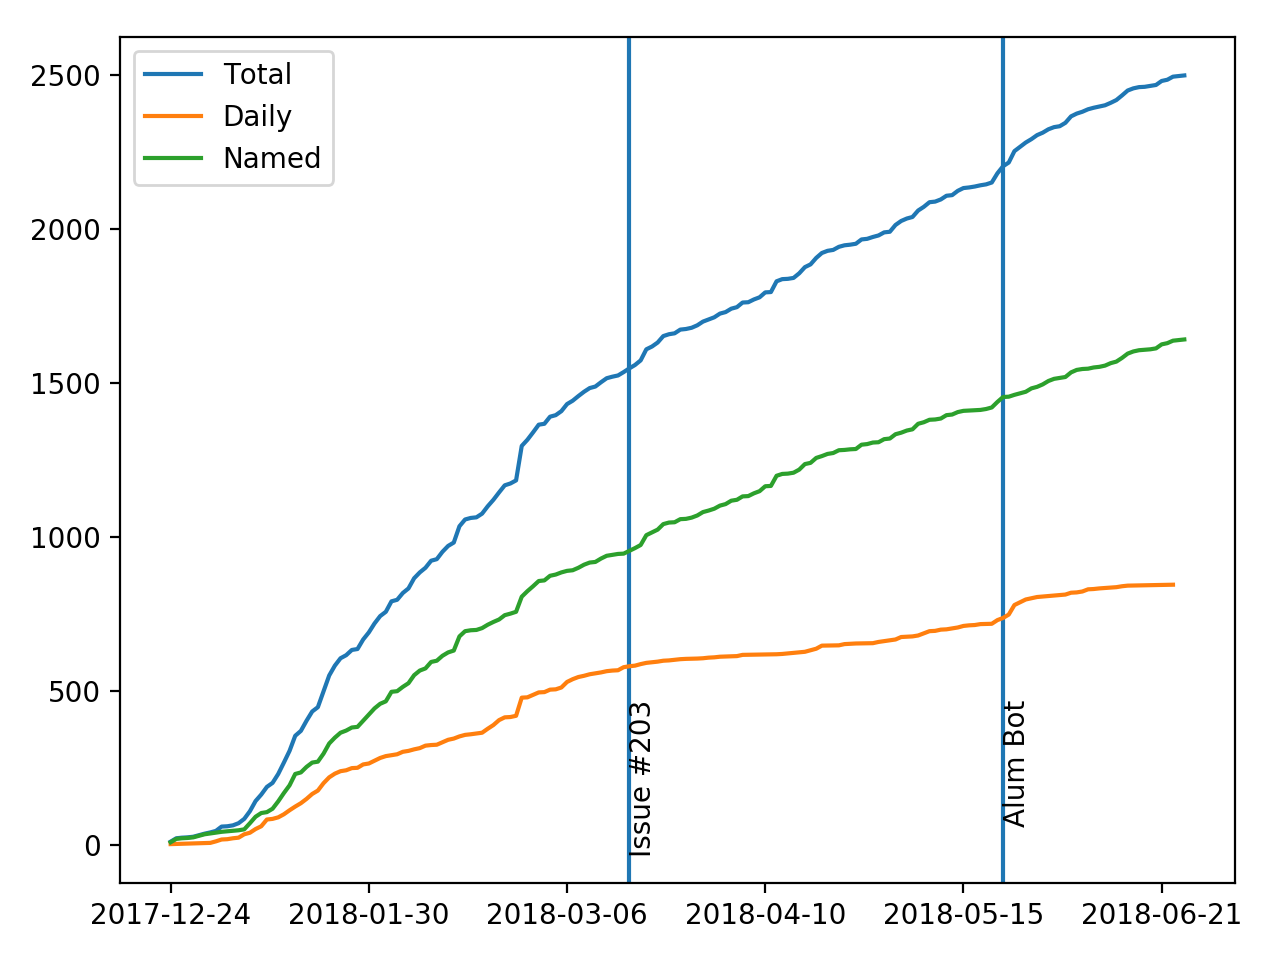

In [68]:
visualize(xoffset=400, interval=35, ndays=180)

<IPython.core.display.Javascript object>


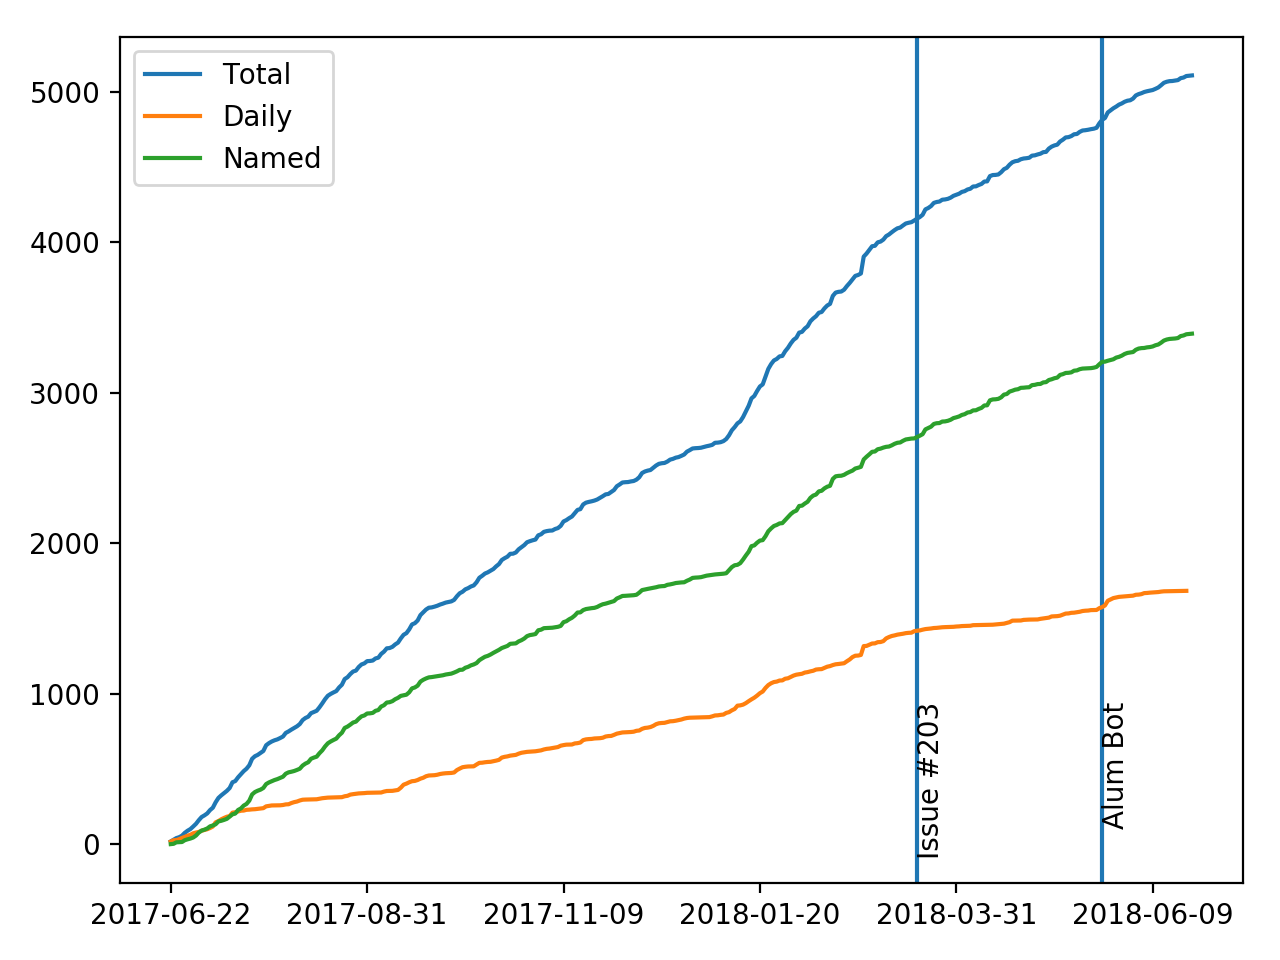

In [69]:
visualize(xoffset=800, interval=70, ndays=365)

<IPython.core.display.Javascript object>


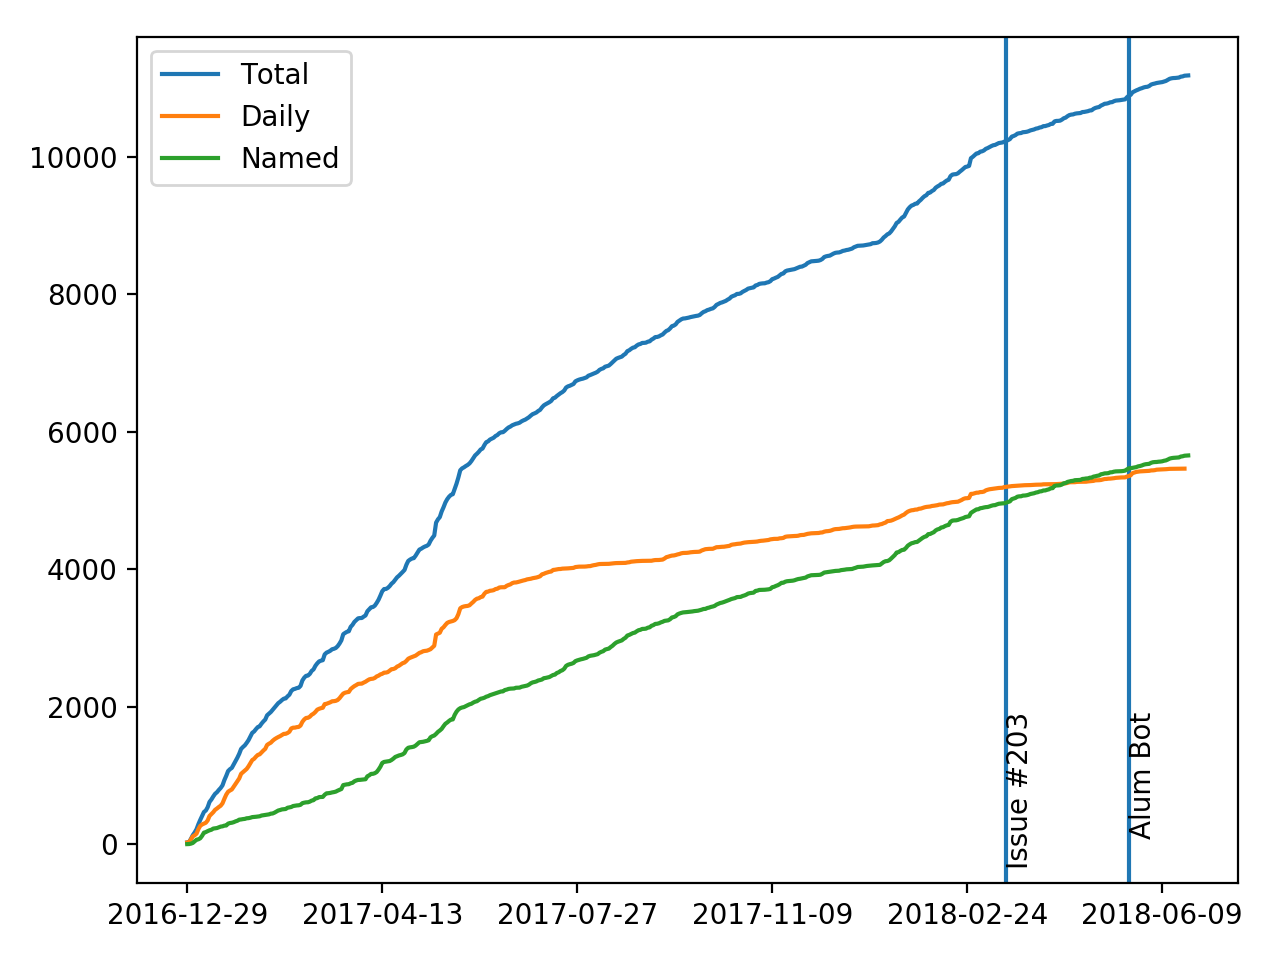

In [72]:
visualize(xoffset=1600, interval=105, ndays=540)